In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.model_selection import train_test_split

import random
import os
import re
import cv2
import sys

import keras
from keras.optimizers import Adam
from keras.layers import Dense
from keras.backend import sigmoid
from keras.applications.resnet50 import preprocess_input

import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------------------
 
# from sklearn.datasets import load_sample_images
# from sklearn.datasets import load_digits
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.metrics import accuracy_score, plot_confusion_matrix
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.wrappers import scikit_learn
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
# import matplotlib.pyplot as plt
# import seaborn as sns
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
# from keras.preprocessing.image import ImageDataGenerator
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report,confusion_matrix
# from keras.callbacks import ReduceLROnPlateau
# import cv2
# import os

# IMAGE PREPROCESSING

In [77]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 180
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [78]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [79]:
train = get_data(r'C:\Users\Chris\Documents\Flatiron\fourth_projekt\Project-The-Fourth-Pneumonia-X-Ray\data\dataset\train')
test  = get_data(r'C:\Users\Chris\Documents\Flatiron\fourth_projekt\Project-The-Fourth-Pneumonia-X-Ray\data\dataset\test')

In [80]:
train_set, val_set = train_test_split(train, test_size=0.10, random_state=22)

print("The number of files in the train set is: {}, in the validation set is: {} and in the test set is: {}"
      .format(len(train_set), len(val_set), len(test)))

The number of files in the train set is: 4244, in the validation set is: 472 and in the test set is: 624


<AxesSubplot:ylabel='count'>

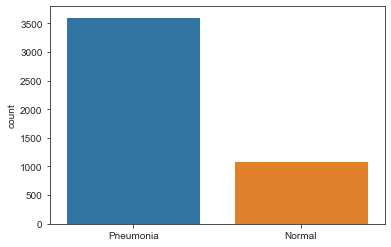

In [81]:
temp_labels = []
for i in train:
    if(i[1] == 0):
        temp_labels.append("Pneumonia")
    else:
        temp_labels.append("Normal")
sns.set_style('ticks')
sns.countplot(temp_labels)

Text(0.5, 1.0, 'PNEUMONIA')

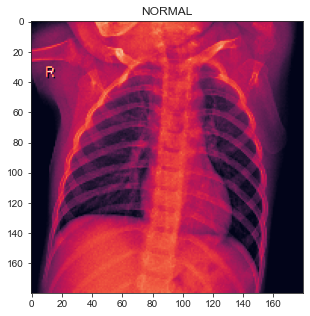

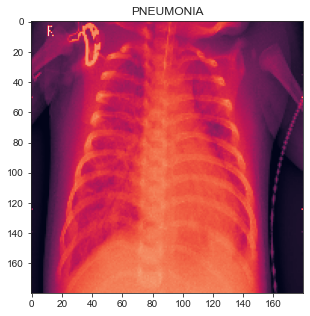

In [82]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[0][0])
plt.title(labels[train[0][1]])

In [83]:
x_train = []
y_train = []
x_test  = []
y_test  = []
x_val   = []
y_val   = []

for feature, label in train_set:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val_set:
    x_val.append(feature)
    y_val.append(label)

In [84]:
x_train = np.array(x_train) / 255
x_val   = np.array(x_val) / 255
x_test  = np.array(x_test) / 255

In [85]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [86]:
train_dir   = r"data/dataset/train"
class_names = ['PNEUMONIA', 'NORMAL']

# Instantiate an instance of ImageDataGenerator with some basic parameters

training_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
        rotation_range                = 30,
        zoom_range                    = 0.2,
        width_shift_range             = 0.1,
        height_shift_range            = 0.1,
        horizontal_flip               = True,
        vertical_flip                 = False,
        )

train_generator = training_generator.flow_from_directory(train_dir,
                                                         target_size      = (96,96),
                                                         batch_size       = 32,
                                                         class_mode       = 'binary',
                                                         classes          = class_names,
                                                         shuffle          = True,
                                                        )

Found 4716 images belonging to 2 classes.


In [87]:
val_dir =  r'data/dataset/val/'

# remember not to augment the test or train data

validation_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = validation_generator.flow_from_directory(val_dir,
                                                         target_size = (96,96),
                                                         batch_size  = 32,
                                                         classes     = class_names,
                                                         class_mode  = 'binary')

Found 516 images belonging to 2 classes.


In [88]:
test_dir =  r'data/dataset/test/'

# remember not to augment the test or train data

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(test_dir,
                                                    target_size = (96,96),
                                                    batch_size  = 32,
                                                    classes     = class_names,
                                                    class_mode  = 'binary')

Found 624 images belonging to 2 classes.


# END OF IMAGE PREPROCESSING

## ----------------------------------------------------------------------------------------------------------------------
# MODELING

In [156]:
auc  = AUC()
rec  = Recall()
prec = Precision()

In [157]:
def plotter(history, epochs):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs_range = range(epochs)

    plt.figure(figsize=(25, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [158]:
def layers1_model(activation = 'relu', last_activation = 'sigmoid', compiler = 'SGD', epochs = 25, batch_size = 64):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,(3,3), input_shape = (96,96,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation = 'relu'),
        tf.keras.layers.Dense(1,activation   = 'sigmoid')  
    ])
    
    model.compile(optimizer = tf.keras.optimizers.SGD(lr       = 0.001,
                                                      momentum = 0.01,
                                                      nesterov = True),
                  loss    = 'binary_crossentropy',
                  metrics = (['acc'], [auc], [rec], [prec]))
        

        
    with tf.device('/device:GPU:0'):
        history = model.fit(train_generator,
                            validation_data = val_generator,
                            epochs = epochs,
                            batch_size = batch_size,
                            verbose = 1)

    plotter(history, epochs)

Epoch 1/25
148/148 [==============================] - 65s 440ms/step - loss: 94.4292 - acc: 0.7477 - auc_33: 0.5104 - recall_38: 0.0299 - precision_29: 0.2157 - val_loss: 0.6885 - val_acc: 0.5233 - val_auc_33: 0.5056 - val_recall_38: 0.0000e+00 - val_precision_29: 0.0000e+00
Epoch 2/25
148/148 [==============================] - 63s 425ms/step - loss: 0.6720 - acc: 0.7659 - auc_33: 0.4989 - recall_38: 0.0000e+00 - precision_29: 0.0000e+00 - val_loss: 0.6883 - val_acc: 0.5233 - val_auc_33: 0.5056 - val_recall_38: 0.0000e+00 - val_precision_29: 0.0000e+00
Epoch 3/25
148/148 [==============================] - 62s 421ms/step - loss: 0.6647 - acc: 0.7661 - auc_33: 0.4940 - recall_38: 0.0000e+00 - precision_29: 0.0000e+00 - val_loss: 0.6884 - val_acc: 0.5233 - val_auc_33: 0.5056 - val_recall_38: 0.0000e+00 - val_precision_29: 0.0000e+00
Epoch 4/25
148/148 [==============================] - 63s 428ms/step - loss: 0.6557 - acc: 0.7659 - auc_33: 0.4998 - recall_38: 0.0000e+00 - precision_29: 0.0

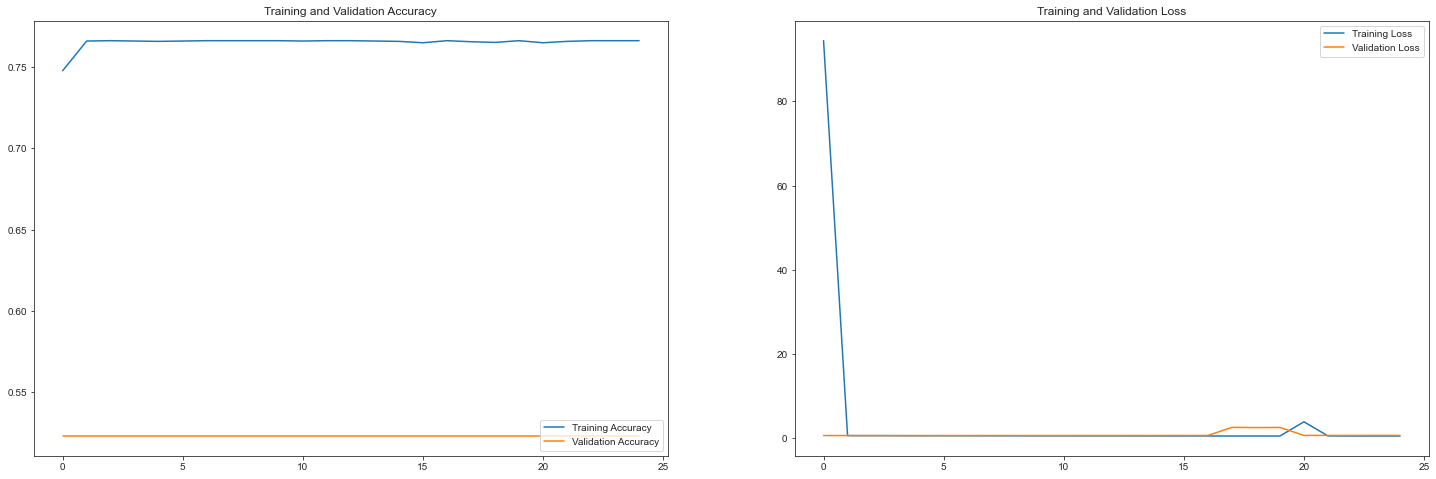

In [159]:
# Lets begin with this structure
# > best score     : N/A
# > previous score : N/A
# > new score      : loss: 0.5825 - acc: 0.7661 - auc_33: 0.5051 - recall_38: 0.0000e+00 - precision_29: 0.0000e+00 - val_loss: 0.7252 - val_acc: 0.5233 - val_auc_33: 0.5074 - val_recall_38: 0.0000e+00 - val_precision_29: 0.0000e+00
layers1_model()

In [160]:
def layers2_model(activation = 'relu', last_activation = 'sigmoid', compiler = 'SGD', epochs = 25, batch_size = 64):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,(3,3), input_shape = (96,96,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
    
        tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
    
        tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
    
        tf.keras.layers.Conv2D(256,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
          
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation = 'relu'),
        tf.keras.layers.Dense(1,activation   = 'sigmoid')  
    ])
    
    model.compile(optimizer = tf.keras.optimizers.SGD(lr       = 0.001,
                                                      momentum = 0.01,
                                                      nesterov = True),
                  loss    = 'binary_crossentropy',
                  metrics = (['acc'], [auc], [rec], [prec]))
        

        
    with tf.device('/device:GPU:0'):
        history = model.fit(train_generator,
                            validation_data = val_generator,
                            epochs = epochs,
                            batch_size = batch_size,
                            verbose = 1)

    plotter(history, epochs)

Epoch 1/25
148/148 [==============================] - 62s 416ms/step - loss: 0.6385 - acc: 0.8206 - auc_33: 0.8043 - recall_38: 0.4485 - precision_29: 0.6348 - val_loss: 0.2680 - val_acc: 0.8857 - val_auc_33: 0.9787 - val_recall_38: 0.9837 - val_precision_29: 0.8148
Epoch 2/25
148/148 [==============================] - 58s 391ms/step - loss: 0.2774 - acc: 0.8870 - auc_33: 0.9279 - recall_38: 0.7199 - precision_29: 0.7800 - val_loss: 0.1874 - val_acc: 0.9264 - val_auc_33: 0.9834 - val_recall_38: 0.9512 - val_precision_29: 0.9000
Epoch 3/25
148/148 [==============================] - 56s 376ms/step - loss: 0.2547 - acc: 0.8972 - auc_33: 0.9399 - recall_38: 0.7425 - precision_29: 0.8029 - val_loss: 0.1796 - val_acc: 0.9264 - val_auc_33: 0.9856 - val_recall_38: 0.9634 - val_precision_29: 0.8910
Epoch 4/25
148/148 [==============================] - 56s 380ms/step - loss: 0.2364 - acc: 0.9061 - auc_33: 0.9501 - recall_38: 0.7715 - precision_29: 0.8167 - val_loss: 0.1626 - val_acc: 0.9380 - va

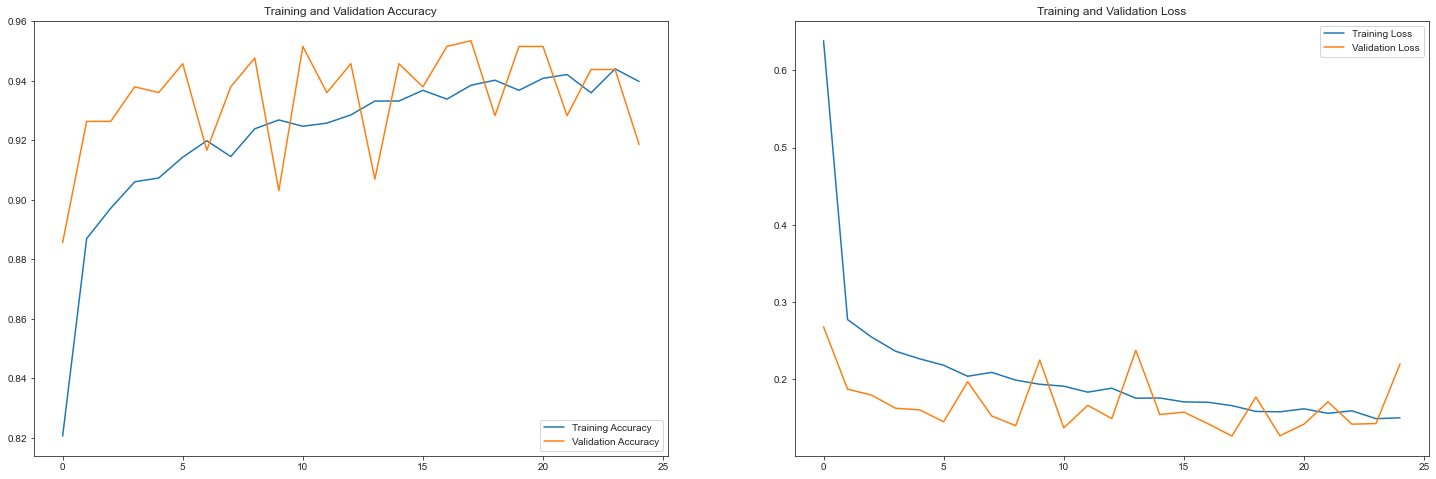

In [161]:
# Lets begin with the well knows SGD for our baseline model
# > best score     : loss: 0.5825 - acc: 0.7661 - auc_33: 0.5051 - recall_38: 0.0000e+00 - precision_29: 0.0000e+00 - val_loss: 0.7252 - val_acc: 0.5233 - val_auc_33: 0.5074 - val_recall_38: 0.0000e+00 - val_precision_29: 0.0000e+00
# > previous score : loss: 0.5825 - acc: 0.7661 - auc_33: 0.5051 - recall_38: 0.0000e+00 - precision_29: 0.0000e+00 - val_loss: 0.7252 - val_acc: 0.5233 - val_auc_33: 0.5074 - val_recall_38: 0.0000e+00 - val_precision_29: 0.0000e+00
# > new score      : loss: 0.1502 - acc: 0.9398 - auc_33: 0.9801 - recall_38: 0.8604     - precision_29: 0.8795     - val_loss: 0.2198 - val_acc: 0.9186 - val_auc_33: 0.9897 - val_recall_38: 0.8293     - val_precision_29: 1.0000
layers2_model()

In [ ]:
def layers3_model(activation = 'relu', last_activation = 'sigmoid', compiler = 'SGD', epochs = 25, batch_size = 64):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,(3,3), input_shape = (96,96,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
    
        tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(256,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
          
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256,activation = 'relu'),
        tf.keras.layers.Dense(1,activation   = 'sigmoid')  
    ])
    
    model.compile(optimizer = tf.keras.optimizers.SGD(lr       = 0.001,
                                                      momentum = 0.01,
                                                      nesterov = True),
                  loss    = 'binary_crossentropy',
                  metrics = (['acc'], [auc], [rec], [prec]))
        

        
    with tf.device('/device:GPU:0'):
        history = model.fit(train_generator,
                            validation_data = val_generator,
                            epochs = epochs,
                            batch_size = batch_size,
                            verbose = 1)

    plotter(history, epochs)

In [ ]:
# Lets begin with the well knows SGD for our baseline model
# > previous score : N/A
# > new score      : loss: 0.2591 - acc: 0.8901 - val_loss: 0.3995 - val_acc: 0.7933
layers3_model()

## Optimizers: SGD vs. RMS vs. Adadelta vs. Nadam

the function below makes it possible to adopt these four different optimizer

In [ ]:
def first_model(activation = 'relu', last_activation = 'sigmoid', optimizer = 'SGD', epochs = 25, batch_size = 64):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,(3,3), input_shape = (96,96,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
    
        tf.keras.layers.Conv2D(64,(3,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(128,(3,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(256,(3,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
          
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256,activation = activation),
        tf.keras.layers.Dense(1,activation   = last_activation)  
    ])
    
    if compiler == 'SGD':
        model.compile(optimizer = tf.keras.optimizers.SGD(lr       = 0.001,
                                                          momentum = 0.01,
                                                          nesterov = True),
                      loss    = 'binary_crossentropy',
                      metrics = (['acc'], [auc], [rec], [prec]))
        
    elif compiler == 'Adadelta':
        model.compile(optimizer = tf.keras.optimizers.Adadelta(lr      = 0.0001,
                                                               rho     = 0.95,
                                                               epsilon = 1e-08,
                                                               decay   = 0.0),
                      loss    = 'binary_crossentropy',
                      metrics = (['acc'], [auc], [rec], [prec]))
        
    elif compiler == 'RMS':
        model.compile(optimizer = tf.keras.optimizers.RMSprop(lr      = 0.001,
                                                              rho     = 0.90,
                                                              epsilon = 1e-08,
                                                              decay   = 0.0),
                      loss    = 'binary_crossentropy',
                      metrics = (['acc'], [auc], [rec], [prec]))
        
    elif compiler == 'Nadam':
        model.compile(optimizer = tf.keras.optimizers.Nadam(lr      = 0.0001,
                                                            beta_1  = 0.9,
                                                            beta_2  = 0.999,
                                                            epsilon = 1e-08,
                                                            decay   = 0.0),
                      loss    = 'binary_crossentropy',
                      metrics = (['acc'], [auc], [rec], [prec]))
    else:
        print('Invalid Compiler')
        
    with tf.device('/device:GPU:0'):
        history = model.fit(train_generator,
                            validation_data = val_generator,
                            epochs = epochs,
                            batch_size = batch_size,
                            verbose = 1)

    plotter(history, epochs)

In [124]:
# Lets begin with the well knows SGD for our baseline model
# > previous score : N/A
# > new score      : loss: 0.2591 - acc: 0.8901 - val_loss: 0.3995 - val_acc: 0.7933
first_model(optimizer = 'SGD')

Epoch 1/2
148/148 [==============================] - 60s 403ms/step - loss: 0.9031 - acc: 0.7570 - auc_21: 0.6802 - recall_26: 0.3545 - precision_17: 0.4739 - val_loss: 0.4310 - val_acc: 0.7907 - val_auc_21: 0.9618 - val_recall_26: 0.9797 - val_precision_17: 0.7006
Epoch 2/2
148/148 [==============================] - 60s 404ms/step - loss: 0.3928 - acc: 0.8285 - auc_21: 0.8505 - recall_26: 0.5485 - precision_17: 0.6605 - val_loss: 0.3756 - val_acc: 0.8256 - val_auc_21: 0.9750 - val_recall_26: 0.9878 - val_precision_17: 0.7364


KeyError: <tensorflow.python.keras.metrics.Recall object at 0x000001429F583A00>

Epoch 1/10
164/164 [==============================] - 53s 323ms/step - loss: 2.7262 - acc: 0.6002 - val_loss: 1.1724 - val_acc: 0.5609
Epoch 2/10
164/164 [==============================] - 54s 327ms/step - loss: 2.7318 - acc: 0.6021 - val_loss: 1.1773 - val_acc: 0.5625
Epoch 3/10
164/164 [==============================] - 56s 342ms/step - loss: 2.7232 - acc: 0.6028 - val_loss: 1.1693 - val_acc: 0.5641
Epoch 4/10
164/164 [==============================] - 54s 327ms/step - loss: 2.6752 - acc: 0.6002 - val_loss: 1.1522 - val_acc: 0.5641
Epoch 5/10
164/164 [==============================] - 50s 307ms/step - loss: 2.8346 - acc: 0.6061 - val_loss: 1.1530 - val_acc: 0.5625
Epoch 6/10
164/164 [==============================] - 51s 313ms/step - loss: 2.8000 - acc: 0.6011 - val_loss: 1.1454 - val_acc: 0.5641
Epoch 7/10
164/164 [==============================] - 55s 336ms/step - loss: 2.6680 - acc: 0.6095 - val_loss: 1.1436 - val_acc: 0.5657
Epoch 8/10
164/164 [==============================] - 5

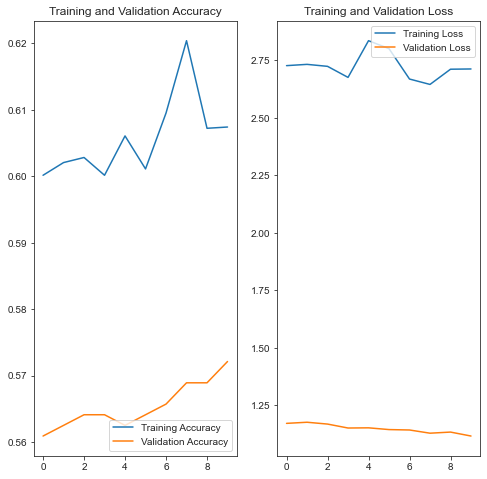

In [118]:
# Lets try Adadelta next
# > previous score : loss: 0.2591 - acc: 0.8901 - val_loss: 0.3995 - val_acc: 0.7933
# > new score      : loss: 2.7118 - acc: 0.6074 - val_loss: 1.1174 - val_acc: 0.5721
# This one is a bit unusual with the validation performing better than the training
first_model(optimizer = 'Adadelta')

Epoch 1/10
164/164 [==============================] - 55s 334ms/step - loss: 1.2312 - acc: 0.7605 - val_loss: 0.4593 - val_acc: 0.8237
Epoch 2/10
164/164 [==============================] - 56s 340ms/step - loss: 0.3651 - acc: 0.8588 - val_loss: 0.6601 - val_acc: 0.8446
Epoch 3/10
164/164 [==============================] - 55s 334ms/step - loss: 0.3351 - acc: 0.8828 - val_loss: 0.3517 - val_acc: 0.8702
Epoch 4/10
164/164 [==============================] - 54s 332ms/step - loss: 0.3032 - acc: 0.8945 - val_loss: 0.3020 - val_acc: 0.8942
Epoch 5/10
164/164 [==============================] - 55s 334ms/step - loss: 0.2833 - acc: 0.8997 - val_loss: 0.3211 - val_acc: 0.8894
Epoch 6/10
164/164 [==============================] - 56s 341ms/step - loss: 0.2674 - acc: 0.9039 - val_loss: 0.4626 - val_acc: 0.7644
Epoch 7/10
164/164 [==============================] - 58s 352ms/step - loss: 0.5103 - acc: 0.9037 - val_loss: 0.4384 - val_acc: 0.9038
Epoch 8/10
164/164 [==============================] - 6

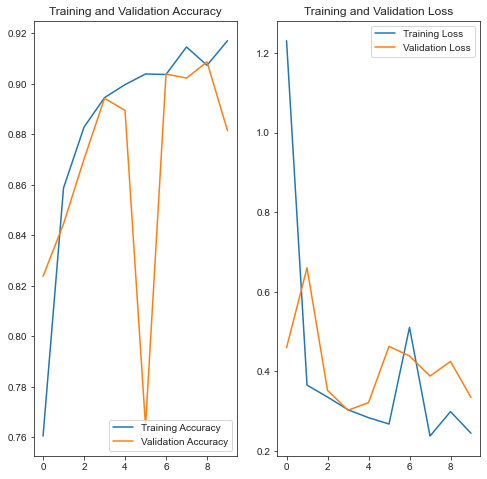

In [119]:
# Lets try RMS next
# > previous score : loss: 2.7118 - acc: 0.6074 - val_loss: 1.1174 - val_acc: 0.5721
# > new score      : loss: 0.2443 - acc: 0.9170 - val_loss: 0.3340 - val_acc: 0.8814
first_model(optimizer = 'RMS')

Epoch 1/10
164/164 [==============================] - 57s 348ms/step - loss: 0.8643 - acc: 0.7676 - val_loss: 0.4109 - val_acc: 0.8237
Epoch 2/10
164/164 [==============================] - 62s 379ms/step - loss: 0.3463 - acc: 0.8635 - val_loss: 0.3452 - val_acc: 0.8606
Epoch 3/10
164/164 [==============================] - 56s 342ms/step - loss: 0.2759 - acc: 0.8899 - val_loss: 0.4252 - val_acc: 0.7965
Epoch 4/10
164/164 [==============================] - 56s 342ms/step - loss: 0.2644 - acc: 0.8882 - val_loss: 0.4770 - val_acc: 0.7740
Epoch 5/10
164/164 [==============================] - 55s 338ms/step - loss: 0.2373 - acc: 0.9019 - val_loss: 0.3154 - val_acc: 0.8542
Epoch 6/10
164/164 [==============================] - 55s 335ms/step - loss: 0.2283 - acc: 0.9065 - val_loss: 0.2867 - val_acc: 0.8990
Epoch 7/10
164/164 [==============================] - 55s 335ms/step - loss: 0.2141 - acc: 0.9174 - val_loss: 0.3248 - val_acc: 0.8365
Epoch 8/10
164/164 [==============================] - 5

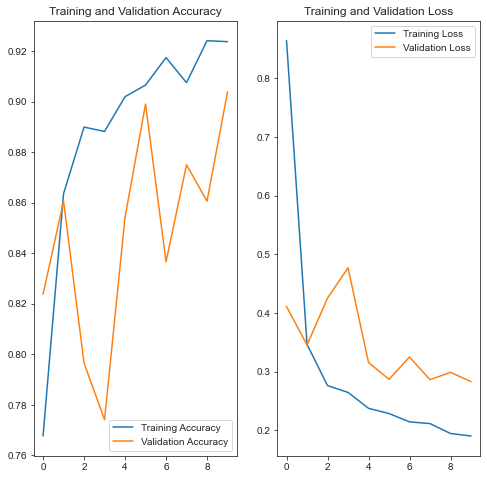

In [120]:
# Nadam seems to work much better than the rest. lets stick to this compiler
# > previous score : loss: 0.2443 - acc: 0.9170 - val_loss: 0.3340 - val_acc: 0.8814
# > new score      : loss: 0.1900 - acc: 0.9237 - val_loss: 0.2827 - val_acc: 0.9038
first_model(optimizer = 'Nadam')

## Activation Functions: Sigmoid vs. ReLu vs. Swish

In [159]:
# swish is a recent activation function that is said to remedy the issues of ReLU. Lets put it to the test
def swish(x, b = 1):
    return (x * sigmoid(b * x))

Epoch 1/10
164/164 [==============================] - 56s 340ms/step - loss: 0.5842 - acc: 0.7391 - val_loss: 0.6827 - val_acc: 0.6250
Epoch 2/10
164/164 [==============================] - 55s 336ms/step - loss: 0.5673 - acc: 0.7416 - val_loss: 0.6079 - val_acc: 0.6234
Epoch 3/10
164/164 [==============================] - 55s 334ms/step - loss: 0.4322 - acc: 0.7710 - val_loss: 0.4220 - val_acc: 0.8109
Epoch 4/10
164/164 [==============================] - 56s 339ms/step - loss: 0.3158 - acc: 0.8565 - val_loss: 0.4993 - val_acc: 0.7692
Epoch 5/10
164/164 [==============================] - 56s 339ms/step - loss: 0.2992 - acc: 0.8649 - val_loss: 0.4735 - val_acc: 0.7788
Epoch 6/10
164/164 [==============================] - 55s 337ms/step - loss: 0.2874 - acc: 0.8677 - val_loss: 0.5176 - val_acc: 0.7404
Epoch 7/10
164/164 [==============================] - 55s 336ms/step - loss: 0.2879 - acc: 0.8698 - val_loss: 0.4972 - val_acc: 0.7516
Epoch 8/10
164/164 [==============================] - 5

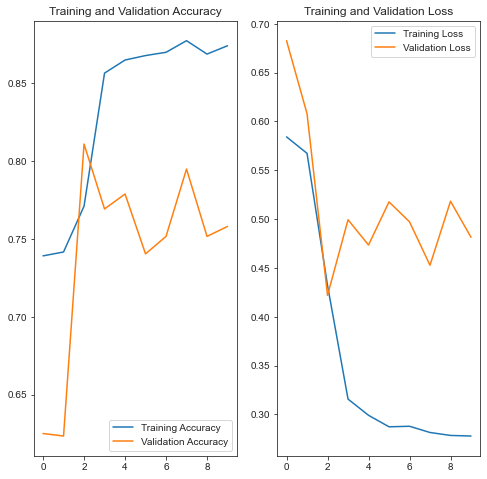

In [122]:
# ReLU is known to work better than sigmoid in most cases, lets try nonetheless
# > previous score : loss: 0.1900 - acc: 0.9237 - val_loss: 0.2827 - val_acc: 0.9038
# > new score      : loss: 0.1992 - acc: 0.9192 - val_loss: 0.1726 - val_acc: 0.9438
first_model(optimizer = 'Nadam', activation = 'sigmoid')

Epoch 1/10
164/164 [==============================] - 55s 336ms/step - loss: 1.1983 - acc: 0.7500 - val_loss: 0.3915 - val_acc: 0.8093
Epoch 2/10
164/164 [==============================] - 53s 323ms/step - loss: 0.3403 - acc: 0.8599 - val_loss: 0.3591 - val_acc: 0.8429
Epoch 3/10
164/164 [==============================] - 54s 326ms/step - loss: 0.2805 - acc: 0.8880 - val_loss: 0.4344 - val_acc: 0.7949
Epoch 4/10
164/164 [==============================] - 54s 327ms/step - loss: 0.2554 - acc: 0.8979 - val_loss: 0.3069 - val_acc: 0.8686
Epoch 5/10
164/164 [==============================] - 55s 332ms/step - loss: 0.2412 - acc: 0.9025 - val_loss: 0.3654 - val_acc: 0.8269
Epoch 6/10
164/164 [==============================] - 53s 323ms/step - loss: 0.2204 - acc: 0.9121 - val_loss: 0.3227 - val_acc: 0.8526
Epoch 7/10
164/164 [==============================] - 55s 338ms/step - loss: 0.2255 - acc: 0.9067 - val_loss: 0.3122 - val_acc: 0.8510
Epoch 8/10
164/164 [==============================] - 5

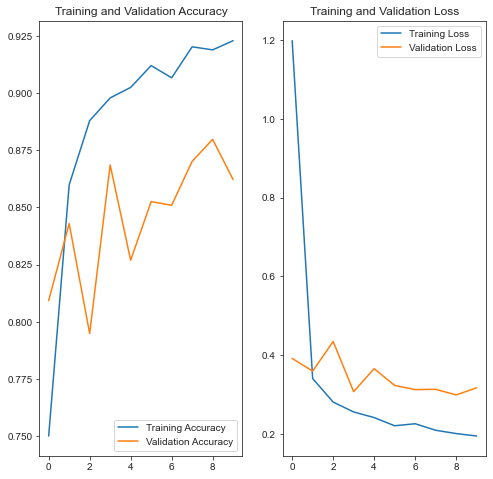

In [123]:
# We already know ReLU will score higer from the results of the previous section
# > previous score : loss: 0.2779 - acc: 0.8740 - val_loss: 0.4814 - val_acc: 0.7580
# > new score      : loss: 0.1992 - acc: 0.9192 - val_loss: 0.1726 - val_acc: 0.9438
first_model(optimizer = 'Nadam', activation = 'relu')

Epoch 1/10
148/148 [==============================] - 49s 334ms/step - loss: 1.2829 - acc: 0.7366 - val_loss: 0.3707 - val_acc: 0.8430
Epoch 2/10
148/148 [==============================] - 50s 337ms/step - loss: 0.3892 - acc: 0.8433 - val_loss: 0.2672 - val_acc: 0.8934
Epoch 3/10
148/148 [==============================] - 49s 330ms/step - loss: 0.3129 - acc: 0.8749 - val_loss: 0.2349 - val_acc: 0.9225
Epoch 4/10
148/148 [==============================] - 50s 337ms/step - loss: 0.2511 - acc: 0.8965 - val_loss: 0.1818 - val_acc: 0.9341
Epoch 5/10
148/148 [==============================] - 49s 334ms/step - loss: 0.2494 - acc: 0.8991 - val_loss: 0.2252 - val_acc: 0.9050
Epoch 6/10
148/148 [==============================] - 50s 335ms/step - loss: 0.2216 - acc: 0.9101 - val_loss: 0.1810 - val_acc: 0.9322
Epoch 7/10
148/148 [==============================] - 50s 339ms/step - loss: 0.2139 - acc: 0.9122 - val_loss: 0.1730 - val_acc: 0.9360
Epoch 8/10
148/148 [==============================] - 5

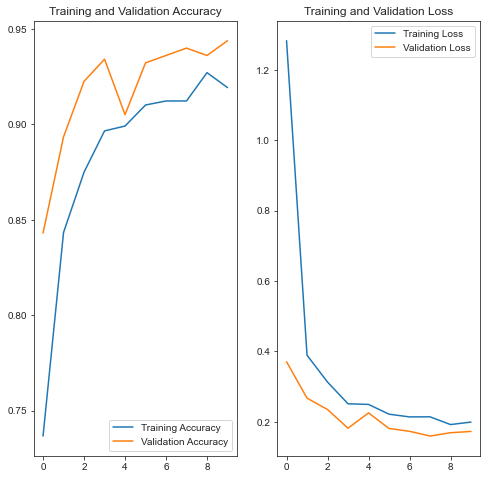

In [165]:
# Lets see if swish can do even better
# > previous score : loss: 0.1943 - acc: 0.9230 - val_loss: 0.3167 - val_acc: 0.8622
# > new score      : loss: 0.1992 - acc: 0.9192 - val_loss: 0.1726 - val_acc: 0.9438
# 
first_model(optimizer = 'Nadam', activation = 'swish')

# looks like Nadam and Swish are the best in this scenario
# In our second model lets remove these features as varaibles and add variability to our ImageDataGenerator

In [171]:
def second_model(activation = 'swish', last_activation = 'sigmoid', epochs = 25,
                batch_size = 64, vert_flip = False, horiz_flip = True, zca = False,
                zoom = .2, rotate = 30, width_shift = .1, height_shift = .1, shuffle = True):
    
    training_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        zca_whitening                 = zca,
        rotation_range                = rotate,
        zoom_range                    = zoom,
        width_shift_range             = width_shift,
        height_shift_range            = height_shift,
        horizontal_flip               = horiz_flip,
        vertical_flip                 = vert_flip,
        )

    train_generator = training_generator.flow_from_directory(train_dir,
                                                             target_size      = (96,96),
                                                             batch_size       = 32,
                                                             class_mode       = 'binary',
                                                             classes          = class_names,
                                                             shuffle          = True,
                                                        )
    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,(3,3), input_shape = (96,96,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
    
        tf.keras.layers.Conv2D(64,(3,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(128,(3,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(256,(3,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
          
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256,activation = activation),
        tf.keras.layers.Dense(1,activation   = last_activation)  
    ])
        
    model.compile(optimizer = tf.keras.optimizers.Nadam(lr      = 0.0001,
                                                        beta_1  = 0.9,
                                                        beta_2  = 0.999,
                                                        epsilon = 1e-08,
                                                        decay   = 0.0),
                  loss    = 'binary_crossentropy',
                  metrics = (['acc'], [auc], [rec], [prec]))
        
    with tf.device('/device:GPU:0'):
        history = model.fit(train_generator,
                            validation_data = val_generator,
                            epochs          = epochs,
                            batch_size      = batch_size,
                            verbose         = 1)
    
    plotter(history, epochs)

# Testing augmentation parameters

Found 4716 images belonging to 2 classes.
Epoch 1/10
148/148 [==============================] - 49s 333ms/step - loss: 0.8932 - acc: 0.7771 - val_loss: 0.2006 - val_acc: 0.9244
Epoch 2/10
148/148 [==============================] - 50s 336ms/step - loss: 0.3204 - acc: 0.8728 - val_loss: 0.1716 - val_acc: 0.9341
Epoch 3/10
148/148 [==============================] - 50s 337ms/step - loss: 0.2676 - acc: 0.8944 - val_loss: 0.1599 - val_acc: 0.9477
Epoch 4/10
148/148 [==============================] - 50s 336ms/step - loss: 0.2456 - acc: 0.8972 - val_loss: 0.1777 - val_acc: 0.9554
Epoch 5/10
148/148 [==============================] - 49s 334ms/step - loss: 0.2310 - acc: 0.9018 - val_loss: 0.1482 - val_acc: 0.9535
Epoch 6/10
148/148 [==============================] - 49s 332ms/step - loss: 0.2127 - acc: 0.9099 - val_loss: 0.1413 - val_acc: 0.9535
Epoch 7/10
148/148 [==============================] - 50s 335ms/step - loss: 0.1946 - acc: 0.9222 - val_loss: 0.1451 - val_acc: 0.9574
Epoch 8/10
14

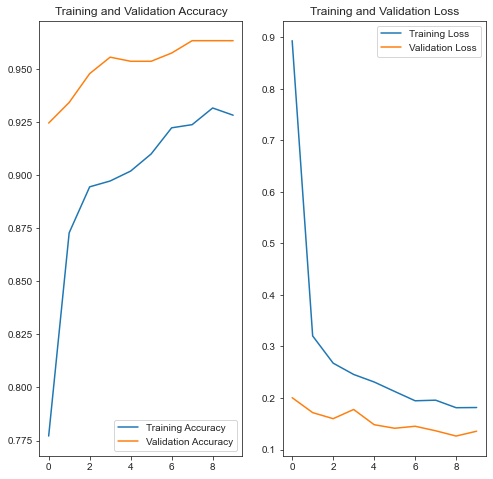

In [173]:
# Lets see if my guess of enabling horizontal flipping from the beginning was correct
# > previous score : loss: 0.2354 - acc: 0.9059 - val_loss: 0.1883 - val_acc: 0.9419
# > new score      : loss: 0.1815 - acc: 0.9281 - val_loss: 0.1355 - val_acc: 0.9632
# Looks like I was wrong on this one, turning this off significantly increased preformance
second_model(horiz_flip = False)

Found 4716 images belonging to 2 classes.
Epoch 1/10
148/148 [==============================] - 50s 338ms/step - loss: 1.1188 - acc: 0.7525 - val_loss: 0.2722 - val_acc: 0.9012
Epoch 2/10
148/148 [==============================] - 49s 332ms/step - loss: 0.3747 - acc: 0.8478 - val_loss: 0.2340 - val_acc: 0.9244
Epoch 3/10
148/148 [==============================] - 50s 335ms/step - loss: 0.3064 - acc: 0.8806 - val_loss: 0.2022 - val_acc: 0.9302
Epoch 4/10
148/148 [==============================] - 50s 336ms/step - loss: 0.2669 - acc: 0.8846 - val_loss: 0.2524 - val_acc: 0.9109
Epoch 5/10
148/148 [==============================] - 49s 333ms/step - loss: 0.2600 - acc: 0.8921 - val_loss: 0.2010 - val_acc: 0.9186
Epoch 6/10
148/148 [==============================] - 49s 332ms/step - loss: 0.2335 - acc: 0.9018 - val_loss: 0.2247 - val_acc: 0.9322
Epoch 7/10
148/148 [==============================] - 50s 335ms/step - loss: 0.2181 - acc: 0.9122 - val_loss: 0.1609 - val_acc: 0.9438
Epoch 8/10
14

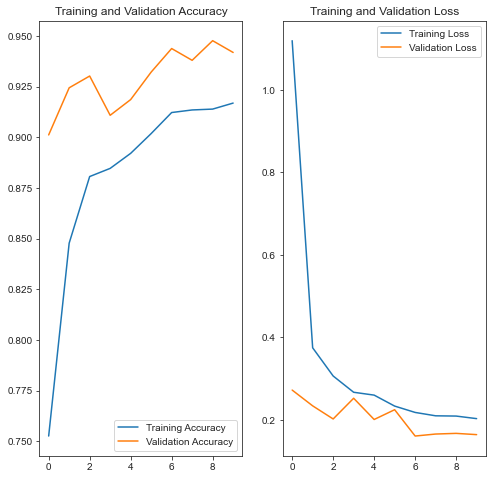

In [176]:
# Since I guessed wrong on horizontal flipping, lets go against intuition and set vertical flipping to true
# > previous score : loss: 0.1815 - acc: 0.9281 - val_loss: 0.1355 - val_acc: 0.9632
# > new score      : loss: 0.2030 - acc: 0.9169 - val_loss: 0.1643 - val_acc: 0.9419
# Wrong again, this brings us back down to horizontal flipping score
second_model(vert_flip = True, horiz_flip = False)

Found 4716 images belonging to 2 classes.
Epoch 1/10
148/148 [==============================] - 49s 333ms/step - loss: 0.9929 - acc: 0.7593 - val_loss: 0.2589 - val_acc: 0.9050
Epoch 2/10
148/148 [==============================] - 50s 338ms/step - loss: 0.3691 - acc: 0.8586 - val_loss: 0.2948 - val_acc: 0.8779
Epoch 3/10
148/148 [==============================] - 49s 333ms/step - loss: 0.2786 - acc: 0.8916 - val_loss: 0.2053 - val_acc: 0.9167
Epoch 4/10
148/148 [==============================] - 49s 333ms/step - loss: 0.2390 - acc: 0.9016 - val_loss: 0.1997 - val_acc: 0.9186
Epoch 5/10
148/148 [==============================] - 50s 335ms/step - loss: 0.2261 - acc: 0.9075 - val_loss: 0.1670 - val_acc: 0.9380
Epoch 6/10
148/148 [==============================] - 50s 338ms/step - loss: 0.2170 - acc: 0.9116 - val_loss: 0.1784 - val_acc: 0.9322
Epoch 7/10
148/148 [==============================] - 49s 333ms/step - loss: 0.2007 - acc: 0.9154 - val_loss: 0.1618 - val_acc: 0.9535
Epoch 8/10
14

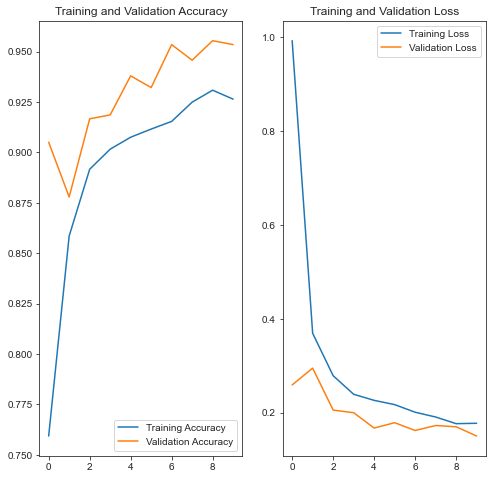

In [177]:
# fully understanding zca whitening would quite the task to undertake. Thankfully we dont need to for us to see if it helps. 
# > previous score : loss: 0.1815 - acc: 0.9281 - val_loss: 0.1355 - val_acc: 0.9632
# > new score      : loss: 0.1772 - acc: 0.9264 - val_loss: 0.1500 - val_acc: 0.9535
# A slight detriment compared to our best
second_model(zca = True, horiz_flip = False)

Found 4716 images belonging to 2 classes.
Epoch 1/10
148/148 [==============================] - 49s 333ms/step - loss: 0.9808 - acc: 0.7682 - val_loss: 0.2083 - val_acc: 0.9264
Epoch 2/10
148/148 [==============================] - 48s 324ms/step - loss: 0.3360 - acc: 0.8721 - val_loss: 0.2128 - val_acc: 0.9031
Epoch 3/10
148/148 [==============================] - 48s 324ms/step - loss: 0.2455 - acc: 0.9014 - val_loss: 0.1599 - val_acc: 0.9341
Epoch 4/10
148/148 [==============================] - 48s 324ms/step - loss: 0.2122 - acc: 0.9169 - val_loss: 0.1329 - val_acc: 0.9516
Epoch 5/10
148/148 [==============================] - 48s 323ms/step - loss: 0.1954 - acc: 0.9220 - val_loss: 0.1289 - val_acc: 0.9632
Epoch 6/10
148/148 [==============================] - 48s 323ms/step - loss: 0.1808 - acc: 0.9251 - val_loss: 0.1251 - val_acc: 0.9593
Epoch 7/10
148/148 [==============================] - 48s 323ms/step - loss: 0.1581 - acc: 0.9336 - val_loss: 0.1167 - val_acc: 0.9516
Epoch 8/10
14

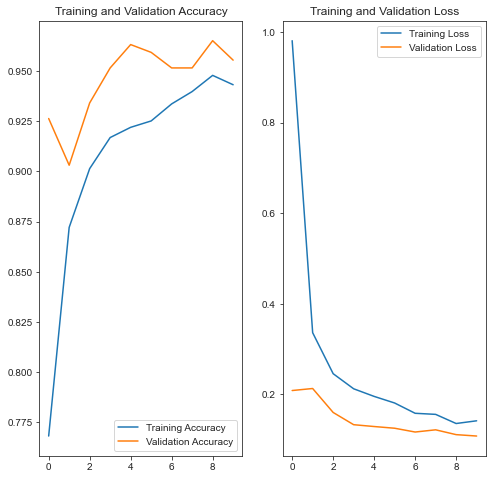

In [178]:
# many of the pictures appear zoomed in at different levels already, lets see if the variable zoom was helping or hurting our model
# > previous score : loss: 0.1815 - acc: 0.9281 - val_loss: 0.1355 - val_acc: 0.9632
# > new score      : loss: 0.1415 - acc: 0.9432 - val_loss: 0.1079 - val_acc: 0.9554
# The model is much better with this feature, lets continue with it
second_model(zoom = 0 ,horiz_flip = False)

Found 4716 images belonging to 2 classes.
Epoch 1/10
148/148 [==============================] - 50s 341ms/step - loss: 1.4205 - acc: 0.7721 - val_loss: 0.2056 - val_acc: 0.9264
Epoch 2/10
148/148 [==============================] - 50s 341ms/step - loss: 0.3511 - acc: 0.8711 - val_loss: 0.1740 - val_acc: 0.9322
Epoch 3/10
148/148 [==============================] - 50s 341ms/step - loss: 0.2607 - acc: 0.8991 - val_loss: 0.1682 - val_acc: 0.9457
Epoch 4/10
148/148 [==============================] - 51s 343ms/step - loss: 0.2193 - acc: 0.9186 - val_loss: 0.1464 - val_acc: 0.9457
Epoch 5/10
148/148 [==============================] - 53s 359ms/step - loss: 0.2049 - acc: 0.9179 - val_loss: 0.1188 - val_acc: 0.9535
Epoch 6/10
148/148 [==============================] - 53s 356ms/step - loss: 0.1778 - acc: 0.9319 - val_loss: 0.1192 - val_acc: 0.9516
Epoch 7/10
148/148 [==============================] - 51s 343ms/step - loss: 0.1523 - acc: 0.9438 - val_loss: 0.1058 - val_acc: 0.9574
Epoch 8/10
14

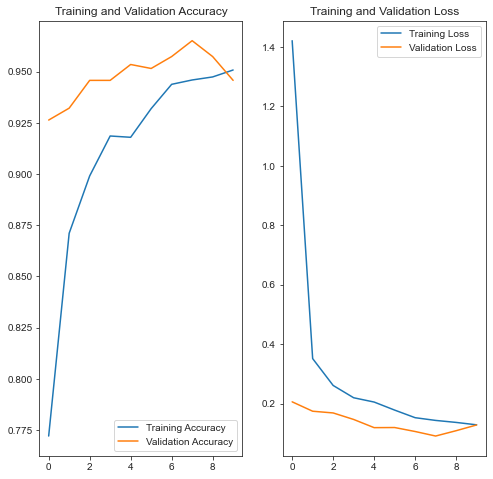

In [180]:
# fully understanding zca whitening would quite the task to undertake. Thankfully we dont need to for us to see if it helps. 
# > previous score : loss: 0.1415 - acc: 0.9432 - val_loss: 0.1079 - val_acc: 0.9554
# > new score      : loss: 0.1283 - acc: 0.9508 - val_loss: 0.1278 - val_acc: 0.9457
# Looks like I was wrong on this one, turning this off significantly increased preformance
second_model(rotate = 0, zoom = 0, horiz_flip = False)

# Increasing Resolution

In [ ]:
# lets try increasing the resolution of the model to 128x128

In [46]:
def third_model(activation = 'swish', last_activation = 'sigmoid', epochs = 25,
                batch_size = 32, vert_flip = False, horiz_flip = False, zca = False,
                zoom = 0, rotate = 0, width_shift = .1, height_shift = .1, shuffle = True,
                res = 128, save = False):  

    training_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        zca_whitening                 = zca,
        rotation_range                = rotate,
        zoom_range                    = zoom,
        width_shift_range             = width_shift,
        height_shift_range            = height_shift,
        horizontal_flip               = horiz_flip,
        vertical_flip                 = vert_flip,
        )
    
    validation_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
    val_generator = validation_generator.flow_from_directory(val_dir,
                                                         target_size = (res,res),
                                                         batch_size  = batch_size,
                                                         classes     = class_names,
                                                         class_mode  = 'binary')

    train_generator = training_generator.flow_from_directory(train_dir,
                                                             target_size      = (res,res),
                                                             batch_size       = batch_size,
                                                             class_mode       = 'binary',
                                                             classes          = class_names,
                                                             shuffle          = True,
                                                        )
    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,(3,3), input_shape = (res,res,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
    
        tf.keras.layers.Conv2D(64,(3,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(128,(3,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(256,(3,3), activation = activation),
        tf.keras.layers.MaxPooling2D(2,2),
          
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256,activation = activation),
        tf.keras.layers.Dense(1,activation   = last_activation)  
    ])
      
    model.compile(optimizer = tf.keras.optimizers.Nadam(lr      = 0.0001,
                                                        beta_1  = 0.9,
                                                        beta_2  = 0.999,
                                                        epsilon = 1e-08,
                                                        decay   = 0.0),
                      loss    = 'binary_crossentropy',
                      metrics = (['acc'], [auc], [rec], [prec]))
    
    with tf.device('/device:GPU:0'):
        history = model.fit(train_generator,
                            validation_data = val_generator,
                            epochs          = epochs,
                            batch_size      = batch_size,
                            verbose         = 1)
    
    plotter(history, epochs)

Found 516 images belonging to 2 classes.
Found 4716 images belonging to 2 classes.
Epoch 1/10
148/148 [==============================] - 57s 386ms/step - loss: 0.8979 - acc: 0.7950 - val_loss: 0.2081 - val_acc: 0.9283
Epoch 2/10
148/148 [==============================] - 57s 385ms/step - loss: 0.2473 - acc: 0.9037 - val_loss: 0.1611 - val_acc: 0.9457
Epoch 3/10
148/148 [==============================] - 56s 377ms/step - loss: 0.1960 - acc: 0.9264 - val_loss: 0.1426 - val_acc: 0.9535
Epoch 4/10
148/148 [==============================] - 55s 370ms/step - loss: 0.1668 - acc: 0.9381 - val_loss: 0.1330 - val_acc: 0.9593
Epoch 5/10
148/148 [==============================] - 56s 379ms/step - loss: 0.1447 - acc: 0.9461 - val_loss: 0.1216 - val_acc: 0.9612
Epoch 6/10
148/148 [==============================] - 55s 373ms/step - loss: 0.1364 - acc: 0.9506 - val_loss: 0.1140 - val_acc: 0.9651
Epoch 7/10
148/148 [==============================] - 55s 369ms/step - loss: 0.1346 - acc: 0.9510 - val_los

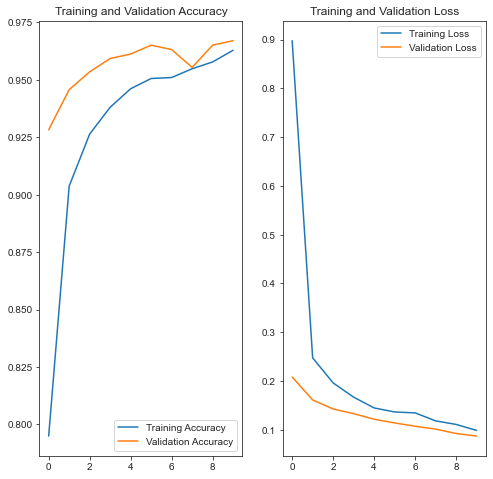

In [188]:
# lets try the model using a resolution of 128 
# > previous score : loss: 0.1283 - acc: 0.9508 - val_loss: 0.1278 - val_acc: 0.9457
# > new score      : loss: 0.0986 - acc: 0.9629 - val_loss: 0.0871 - val_acc: 0.9671
# Wow, thats quite a bit of improvement, lets see if we can improve further
third_model(res = 128)

Found 516 images belonging to 2 classes.
Found 4716 images belonging to 2 classes.
Epoch 1/10
148/148 [==============================] - 86s 579ms/step - loss: 1.2443 - acc: 0.8121 - val_loss: 0.3513 - val_acc: 0.8411
Epoch 2/10
148/148 [==============================] - 86s 584ms/step - loss: 0.2113 - acc: 0.9192 - val_loss: 0.1761 - val_acc: 0.9457
Epoch 3/10
148/148 [==============================] - 84s 567ms/step - loss: 0.1578 - acc: 0.9440 - val_loss: 0.2198 - val_acc: 0.9264
Epoch 4/10
148/148 [==============================] - 82s 551ms/step - loss: 0.1270 - acc: 0.9508 - val_loss: 0.1715 - val_acc: 0.9438
Epoch 5/10
148/148 [==============================] - 82s 553ms/step - loss: 0.1159 - acc: 0.9567 - val_loss: 0.1912 - val_acc: 0.9419
Epoch 6/10
148/148 [==============================] - 83s 558ms/step - loss: 0.1200 - acc: 0.9536 - val_loss: 0.1801 - val_acc: 0.9457
Epoch 7/10
148/148 [==============================] - 83s 558ms/step - loss: 0.1142 - acc: 0.9555 - val_los

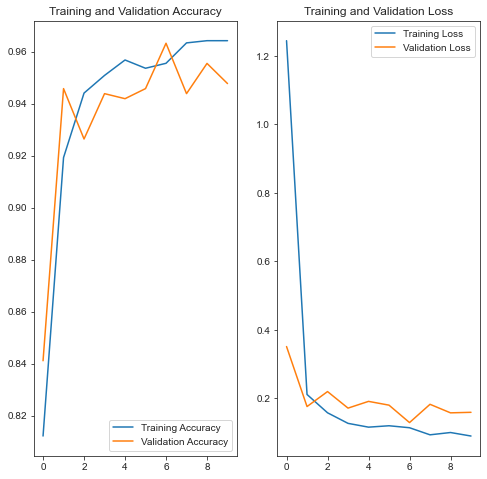

In [190]:
# lets see if we can see even better results using res = 256
# > previous score : loss: 0.0986 - acc: 0.9629 - val_loss: 0.0871 - val_acc: 0.9671
# > new score      : loss: 0.0900 - acc: 0.9642 - val_loss: 0.1592 - val_acc: 0.9477
# The model is starting to take noticeably longer now, and the improvement is a much smaller jump compared to 96 to 128
third_model(res = 256)

Found 516 images belonging to 2 classes.
Found 4716 images belonging to 2 classes.
Epoch 1/10
590/590 [==============================] - 215s 365ms/step - loss: 1.4211 - acc: 0.8804 - val_loss: 6.4147 - val_acc: 0.4787
Epoch 2/10
590/590 [==============================] - 211s 357ms/step - loss: 0.2462 - acc: 0.9324 - val_loss: 0.9141 - val_acc: 0.7771
Epoch 3/10
590/590 [==============================] - 214s 362ms/step - loss: 0.2929 - acc: 0.9372 - val_loss: 5.5832 - val_acc: 0.5155
Epoch 4/10
590/590 [==============================] - 213s 362ms/step - loss: 0.1343 - acc: 0.9493 - val_loss: 2.5065 - val_acc: 0.5407
Epoch 5/10
590/590 [==============================] - 218s 369ms/step - loss: 0.1174 - acc: 0.9555 - val_loss: 4.0876 - val_acc: 0.5620
Epoch 6/10
590/590 [==============================] - 215s 365ms/step - loss: 0.1016 - acc: 0.9610 - val_loss: 3.7238 - val_acc: 0.5620
Epoch 7/10
590/590 [==============================] - 207s 352ms/step - loss: 0.1035 - acc: 0.9599 - 

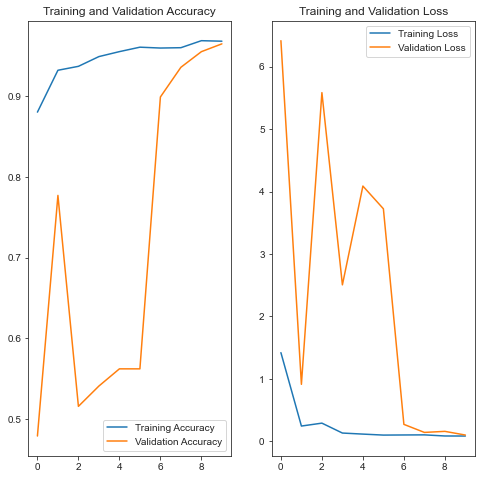

In [198]:
# Lets check the preformance of res = 512 to make sure the performance increase has taperd off
# > previous score : loss: 0.0900 - acc: 0.9642 - val_loss: 0.1592 - val_acc: 0.9477
# > new score      : loss: 0.0865 - acc: 0.9684 - val_loss: 0.1023 - val_acc: 0.9651
# The model is starting to take noticeably longer now, and the improvement is a much smaller jump compared to 96 to 128,
#      aulthough the training data has a good improvement
# I have to lower the batch size to 8 from the default 32 as the larger image size requires more ram than my system has available
third_model(res = 512, batch_size = 8)

Found 516 images belonging to 2 classes.
Found 4716 images belonging to 2 classes.
Epoch 1/135
590/590 [==============================] - 206s 350ms/step - loss: 2.1130 - acc: 0.8855 - val_loss: 9.5478 - val_acc: 0.4767
Epoch 2/135
590/590 [==============================] - 207s 350ms/step - loss: 0.1718 - acc: 0.9353 - val_loss: 4.3850 - val_acc: 0.4767
Epoch 3/135
590/590 [==============================] - 207s 350ms/step - loss: 0.1517 - acc: 0.9413 - val_loss: 0.6074 - val_acc: 0.6550
Epoch 4/135
590/590 [==============================] - 206s 349ms/step - loss: 0.2141 - acc: 0.9442 - val_loss: 0.7281 - val_acc: 0.6279
Epoch 5/135
590/590 [==============================] - 205s 347ms/step - loss: 0.1089 - acc: 0.9601 - val_loss: 0.2012 - val_acc: 0.9186
Epoch 6/135
590/590 [==============================] - 204s 346ms/step - loss: 0.1018 - acc: 0.9606 - val_loss: 0.3982 - val_acc: 0.8411
Epoch 7/135
590/590 [==============================] - 204s 346ms/step - loss: 0.0907 - acc: 0.

Epoch 60/135
590/590 [==============================] - 202s 343ms/step - loss: 0.0142 - acc: 0.9943 - val_loss: 0.0576 - val_acc: 0.9845
Epoch 61/135
590/590 [==============================] - 204s 346ms/step - loss: 0.0194 - acc: 0.9928 - val_loss: 0.1436 - val_acc: 0.9671
Epoch 62/135
590/590 [==============================] - 204s 345ms/step - loss: 0.0166 - acc: 0.9943 - val_loss: 0.1037 - val_acc: 0.9748
Epoch 63/135
590/590 [==============================] - 204s 345ms/step - loss: 0.0170 - acc: 0.9943 - val_loss: 0.0947 - val_acc: 0.9690
Epoch 64/135
590/590 [==============================] - 204s 346ms/step - loss: 0.0228 - acc: 0.9922 - val_loss: 0.0921 - val_acc: 0.9671
Epoch 65/135
590/590 [==============================] - 204s 345ms/step - loss: 0.0155 - acc: 0.9955 - val_loss: 0.0578 - val_acc: 0.9826
Epoch 66/135
590/590 [==============================] - 204s 345ms/step - loss: 0.0163 - acc: 0.9941 - val_loss: 0.1398 - val_acc: 0.9612
Epoch 67/135
590/590 [============

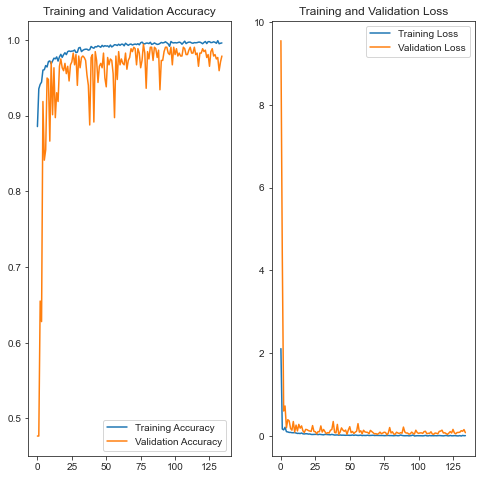

In [199]:
# Lets check the preformance of res = 512 to make sure the performance increase has taperd off
# > previous score : loss: 0.0865 - acc: 0.9684 - val_loss: 0.1023 - val_acc: 0.9651
# > new score      : loss: 0.0127 - acc: 0.9960 - val_loss: 0.0841 - val_acc: 0.9787
# The model is starting to take noticeably longer now, and the improvement is a much smaller jump compared to 96 to 128,
third_model(res = 512,
            epochs = 135,
            batch_size = 8)

# Adding layers

In [ ]:
# model four
# Including three additional BatchNormalization layers
# > previous score : loss: 0.0127 - acc: 0.9960 - val_loss: 0.0841 - val_acc: 0.9787
# > new score      : loss: 0.0223 - acc: 0.9919 - val_loss: 0.0737 - val_acc: 0.9787
# adding BatchNormalization layers have given us our biggest performance increase yet
# we were able to achieve comprable performance to our previous 135 epochs in just 10!

In [48]:
res = 512
batch_size = 8
epochs = 10

training_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = training_generator.flow_from_directory(train_dir,
                                                         target_size      = (res,res),
                                                         batch_size       = batch_size,
                                                         class_mode       = 'binary',
                                                         classes          = class_names,
                                                         shuffle          = True,
                                                        )
    
validation_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = validation_generator.flow_from_directory(val_dir,
                                                         target_size = (res,res),
                                                         batch_size  = batch_size,
                                                         classes     = class_names,
                                                         class_mode  = 'binary')


    
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), input_shape = (res,res,3), activation = 'swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3), activation = 'swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128,(3,3), activation = 'swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256,(3,3), activation = 'swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
          
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation = 'swish'),
    tf.keras.layers.Dense(1,activation   = 'sigmoid')  
])
      
model.compile(optimizer = tf.keras.optimizers.Nadam(lr      = 0.0001,
                                                    beta_1  = 0.9,
                                                    beta_2  = 0.999,
                                                    epsilon = 1e-08,
                                                    decay   = 0.0),
              loss    = 'binary_crossentropy',
              metrics = (['acc'], [auc], [rec], [prec]))
    
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                        validation_data = val_generator,
                        epochs          = epochs,
                        batch_size      = batch_size,
                        verbose         = 1)
    
plotter(history, epochs)

Found 4716 images belonging to 2 classes.
Found 516 images belonging to 2 classes.
Epoch 1/10


ValueError: in user code:

    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\engine\training.py:759 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:388 update_state
        self.build(y_pred, y_true)
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:318 build
        self._metrics = nest.map_structure_up_to(y_pred, self._get_metric_objects,
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\util\nest.py:1135 map_structure_up_to
        return map_structure_with_tuple_paths_up_to(
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\util\nest.py:1234 map_structure_with_tuple_paths_up_to
        results = [func(*args, **kwargs) for args in zip(flat_path_list,
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\util\nest.py:1234 <listcomp>
        results = [func(*args, **kwargs) for args in zip(flat_path_list,
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\util\nest.py:1137 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:419 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:419 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:438 _get_metric_object
        metric_obj = metrics_mod.get(metric)
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\metrics.py:3483 get
        return deserialize(str(identifier))
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\metrics.py:3439 deserialize
        return deserialize_keras_object(
    C:\Users\Chris\anaconda3\envs\tfl\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:377 deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: recall


# Testing zone

In [ ]:
## FSM on test data

In [ ]:
remember early stop idiot
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks = [learning_rate_reduction]

In [ ]:
## Final Model on test data